In [130]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# fix issues with tex
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy as sp
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)


from setup import init_particles, init_A, init_V
from update_rules import update_state, update_A, update_V
from visualize import visualize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Parameters
n = 20          # Total number of particles
T = 6          # Total simulation time
dt = 0.1        # Time step
num_steps = int(T/dt) + 1
d = 2           # Dimensionality (2D)

integration_time = np.linspace(0, T, num_steps)

In [87]:
def init_V(d):
    V = 2*np.random.rand(d, d)-np.ones((d, d))
    V = np.matmul(V, V.T)
    return V

def init_A_eye(d):
    return np.eye(d)

def init_A(d):
    A = 2*np.random.rand(d, d)-np.ones((d, d))
    A = np.matmul(A, A.T)
    return A

def init_x(n, d, num_steps):
    x0 = np.random.uniform(low=-1, high=1, size=(n, d))
    x = np.zeros(shape=(n, num_steps, d))
    x[:, 0, :] = x0
    return x

def init_x_clusters(n, d, num_steps):
    # Let's create two clusters
    n_clusters = 2
    noise = 0.2
    cluster_sep = 2.0
    # clusters mirrored across the origin
    # cluster_centers = [np.array([-cluster_sep/2] * d), np.array([cluster_sep/2] * d)]
    cluster_centers = [np.array([0] * d), np.array([10] * d)]
    x0 = np.zeros((n, d))
    for i in range(n):
        cluster_idx = i % n_clusters
        x0[i] = cluster_centers[cluster_idx] + np.random.normal(scale=noise, size=d)
    x = np.zeros((n, num_steps, d))
    x[:, 0, :] = x0
    return x

def euler_update(attention, V, x, n, dt):
    # TODO: add additional update rules to particle location based on FFN, norm, etc
    for i in range(n):
        dlst = np.array([attention[i][j]*np.matmul(V, x[j][l]) for j in range(n)])
        # sum over j
        dynamics = np.sum(dlst, axis=0)
        # Euler scheme
        x[i][l+1] = x[i][l] + dt*dynamics
    return x

def rk4(attention, V, x, n, dt):
    """Never uses attention matric in its weight update, just self-interaction, also more stable"""
    for i in range(n):
        k1 = dt*np.matmul(V, x[i][l])
        k2 = dt*np.matmul(V, x[i][l] + 0.5*k1)
        k3 = dt*np.matmul(V, x[i][l] + 0.5*k2)
        k4 = dt*np.matmul(V, x[i][l] + k3)
        dynamics = (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i][l+1] = x[i][l] + dynamics
    return x

def rk4_with_attention(attention, V, x, n, dt):
    for i in range(n):
        # k1
        dlst1 = np.array([attention[i][j]*np.matmul(V, x[j][l]) for j in range(n)])
        k1 = dt * np.sum(dlst1, axis=0)
        
        # k2
        x_temp = x.copy()
        x_temp[i][l] += 0.5*k1
        dlst2 = np.array([attention[i][j]*np.matmul(V, x_temp[j][l]) for j in range(n)])
        k2 = dt * np.sum(dlst2, axis=0)
        
        # k3
        x_temp = x.copy()
        x_temp[i][l] += 0.5*k2
        dlst3 = np.array([attention[i][j]*np.matmul(V, x_temp[j][l]) for j in range(n)])
        k3 = dt * np.sum(dlst3, axis=0)
        
        # k4
        x_temp = x.copy()
        x_temp[i][l] += k3
        dlst4 = np.array([attention[i][j]*np.matmul(V, x_temp[j][l]) for j in range(n)])
        k4 = dt * np.sum(dlst4, axis=0)
        
        # Update
        x[i][l+1] = x[i][l] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    return x

In [ ]:
# Define A, V, x
scale = 2.0 # no scaling if 1
V = init_V(d)
A = init_A_eye(d) * scale
print(A)
x = init_x(n, d, num_steps) # init_x_clusters(n, d, num_steps)

# for adding classification objective
labels = np.array([0]*10 + [1]*10)
classification_task = True
learning_rate = 0.01

# for MOS experimetns
K = 2 # num mixture compoennts
pi = np.random.rand(K)
pi /= np.sum(pi)  # Normalize to sum to 1
h = np.random.randn(K, d)  # Context vectors

# visualization cadence params
viz_cadence = 0.3
kmeans_cadence = 1
result_dir = 'post-ln-results'
save_fig=False

## Original Experiments

Low Rank Analysis and cluster divergence

In [ ]:
def compute_attention(A, x, i, j, n):
    """
    Compute attention weight using a softmax-like mechanism for numerical stability.
    
    Args:
        A (np.ndarray): Transformation matrix A of shape (d, d).
        x (np.ndarray): Current particle positions of shape (n, d).
        i (int): Index of the query particle.
        j (int): Index of the key particle.
        n (int): Total number of particles.
    
    Returns:
        float: Attention weight between particle i and j.
    """
    scores = [np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l]) for k in range(n)]
    # Apply softmax in a numerically stable way
    max_score =  np.max(scores) # np.zeros_like(scores)
    exp_scores = np.exp(scores - max_score)
    sum_exp = np.sum(exp_scores)
    attention_weight = 1 / sum_exp
    return attention_weight

def compute_attn_mos(A, x, i, j, n, h, pi):
    attention = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue  # Optional: No self-attention
            scores = []
            for k in range(K):
                # Compute similarity score for mixture component k
                # Adjust the formula based on MoS requirements
                # Here, a simplified dot product is used; adapt as needed
                score = np.dot(h[k], A @ x[i, l]) * np.dot(A @ x[i, l], x[j, l] - x[i, l])
                scores.append(score)
            scores = np.array(scores)  # Shape: (K,)
            # Apply softmax to scores for numerical stability
            max_score = np.max(scores)
            exp_scores = np.exp(scores - max_score)
            softmax_scores = exp_scores / np.sum(exp_scores)
            # Combine softmax scores using mixture weights pi
            attention[i, j] = np.dot(pi, softmax_scores)
    return attention


def vanilla_attn(A, x, i, j, n):
    """from original implementation"""
    return [np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]

In [133]:
def layer_normalize(x, radius=1):
    """
    Normalize each particle's position vector to have a norm equal to the sphere's radius.

    Parameters:
    - x: numpy array of shape (n, d), where n is the number of particles and d is the dimension.
    - radius: float, the radius of the hypersphere.

    Returns:
    - x_normalized: numpy array of shape (n, d), normalized positions.
    """
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    x_normalized = (x / norms) * radius
    return x_normalized

In [ ]:
# simulation loop

for l, t in enumerate(integration_time):
    if l<num_steps-1:
        # Attention matrix
        # attention = [[compute_attention(A, x, i, j, n) for j in range(n)] for i in range(n)]
        attention = [[1/np.sum(vanilla_attn(A, x, i, j, n)) for j in range(n)] for i in range(n)]
        attention = np.array(attention)
        # print(np.linalg.matrix_rank(attention))
        
        label_size = 0
        if round(t % viz_cadence, 10) == 0:
            # ensure the visualization works under larger dimension
            if d > 2:
                pca = PCA(n_components=2)
                reduced_x = pca.fit_transform(x[:, l, :])

                plt.scatter(reduced_x[:, 0], reduced_x[:, 1], c="#d91c72", alpha=1, marker='o', linewidth=0.75, edgecolors='black')
                plt.title(f't = {round(t, 2)}')
                plt.show()
            else:
                label_size = 0
                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)
                label_size = 8
                plt.rcParams['xtick.labelsize'] = label_size
                plt.rcParams['ytick.labelsize'] = label_size 

                ax.set_aspect('equal', adjustable='box')
                # plt.rc('text', usetex=True)
                plt.rc('font', family='serif')
#                 print(A.shape, x[i,l].shape)
#                 print([np.matmul(A, x[i,l])[0] for i in range(n)])
#                 proj = np.matmul(A, x[i,:])
#                 print(proj.shape)
                plt.scatter([np.matmul(A, x[i,l])[0] for i in range(n)],
                            [np.matmul(A, x[i,l])[1] for i in range(n)],
                            c="#a8deb5", 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black', 
                            zorder=3)

                plt.scatter([x[i,l][0] for i in range(n)],
                            [x[i,l][1] for i in range(n)],
                            c="#d91c72", 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black', 
                            zorder=3)

                plt.title(r'$t={t}$'.format(t=str(round(t, 2))), fontsize=20)

                for i in range(n):
                    for j in range(n):
                        if attention[i][j]>1e-4 and i!=j:
                            plt.plot([np.matmul(A, x[i,l])[0], x[j,l][0]], 
                                      [np.matmul(A, x[i,l])[1], x[j,l][1]],
                                      linewidth=attention[i][j]*1e-6,
                                      color="black")

                ax.set_yticklabels([])
                ax.set_xticklabels([])
                
                if save_fig:
                    plt.savefig("{}/connect-{}.pdf".format(result_dir, round(t, 2)), 
                                format='pdf', 
                                bbox_inches='tight')
                else:
                    plt.show()
            
        if round(t % kmeans_cadence, 10) == 0:
            positions = x[:, l, :]
            kmeans = KMeans(n_clusters=2).fit(positions)
            labels_pred = kmeans.labels_
            cluster_centers = kmeans.cluster_centers_
            print(cluster_centers)
            score = silhouette_score(positions, labels_pred)
            distance_between_centers = np.linalg.norm(cluster_centers[0] - cluster_centers[1])
            print(f"Time {t:.2f}: Silhouette Score = {score:.4f} Distance between cluster centers = {distance_between_centers:.4f}")
            
            
        
        # update v if classification
        if classification_task:
            logits = np.matmul(A, x[:, l, :].T).T  # Shape: (n, d)
            logits = np.matmul(logits, V)           # Shape: (n, d)
            # For binary classification, reduce to single logit
            logits = logits[:, 0]                   # Shape: (n,)

            # Compute Loss and Probabilities
            probs = 1 / (1 + np.exp(-logits))       # Sigmoid activation
            loss = -np.mean(labels * np.log(probs + 1e-7) + (1 - labels) * np.log(1 - probs + 1e-7))
            print(f"Time {t:.2f}: Loss = {loss}")

            # Compute Gradient of Loss w.r.t V
            # Gradient for V: x_i * (prob_i - y_i)
            grad_V = np.zeros_like(V)
            for i in range(n):
                grad_V += np.outer(logits[i] * (probs[i] - labels[i]), x[i, l, :])
            grad_V /= n  # Average over particles

            # Update V using Gradient Descent
            V -= learning_rate * grad_V
            
            # maintain symmetry in V
            eigvals, eigvecs = np.linalg.eigh(V)
            eigvals = np.maximum(eigvals, 0)
            V = eigvecs @ np.diag(eigvals) @ eigvecs.T
        
        # perform particle position update
        # there is a massive difference between pre-layer norm and post-layer norm
        
        # x = euler_update(attention, V, x, n, dt)
        
        x = rk4_with_attention(attention, V, x, n, dt)
        x[:, l+1, :] = layer_normalize(x[:, l+1, :], radius=1)
        
        
        

In [ ]:
# Modified simulation loop for your dimensions
for l, t in enumerate(integration_time):
    if l<num_steps-1:
        # Compute queries and keys
        # x[:, l, :] is (20, 2) at timestep l
        # A is (2, 2)
        Q = np.array([np.matmul(A, x[i,l]) for i in range(n)])  # Shape: (20, 2)
        K = x[:, l, :]  # Shape: (20, 2)
        
        # Cross attention scores (20, 20)
        attention = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                attention[i][j] = np.exp(np.dot(Q[i], K[j]) / np.sqrt(2))  # sqrt(d) where d=2
        attention = attention / attention.sum(axis=1, keepdims=True)
        
        # Analyze query clusters
        if round(t % kmeans_cadence, 10) == 0:
            # Cluster the queries
            query_kmeans = KMeans(n_clusters=2).fit(Q)
            query_labels = query_kmeans.labels_
            query_centers = query_kmeans.cluster_centers_
            query_score = silhouette_score(Q, query_labels)
            
            print(f"Time {t:.2f}: Query Clustering Score = {query_score:.4f}")
            
            # Analyze attention patterns per cluster
            for cluster_idx in range(2):
                cluster_mask = query_labels == cluster_idx
                cluster_attention = attention[cluster_mask]
                avg_attention = cluster_attention.mean(axis=0)
                top_k_attended = np.argsort(avg_attention)[-3:]  # Top 3 most attended keys
                print(f"Query Cluster {cluster_idx} (size: {cluster_mask.sum()})")
                print(f"Top attended particle indices: {top_k_attended}")
                print(f"Attention strengths: {avg_attention[top_k_attended]}")
        
        # Visualization with query space
        if round(t % viz_cadence, 10) == 0:
            fig = plt.figure(figsize=(15, 5))
            
            # Plot 1: Query space (Q)
            ax1 = fig.add_subplot(131)
            scatter_q = ax1.scatter(Q[:, 0], Q[:, 1], 
                                  c=query_labels if 'query_labels' in locals() else None,
                                  cmap='viridis', alpha=0.7)
            ax1.set_title('Query Space')
            
            # Plot 2: Key space (original x)
            ax2 = fig.add_subplot(132)
            scatter_x = ax2.scatter(K[:, 0], K[:, 1], c="#d91c72", alpha=0.7)
            ax2.set_title('Key Space (Original)')
            
            # Plot 3: Attention patterns
            ax3 = fig.add_subplot(133)
            # Plot both Q and K points
            scatter_q = ax3.scatter(Q[:, 0], Q[:, 1], c='blue', alpha=0.5, label='Queries')
            scatter_k = ax3.scatter(K[:, 0], K[:, 1], c='red', alpha=0.5, label='Keys')
            
            # Draw attention lines (only for strong attention)
            for i in range(n):
                for j in range(n):
                    if attention[i][j] > 0.1:  # Only show strong attention
                        ax3.plot([Q[i, 0], K[j, 0]], 
                               [Q[i, 1], K[j, 1]],
                               alpha=attention[i][j],
                               color='gray',
                               linewidth=attention[i][j]*2,
                               linestyle='--')
            
            ax3.legend()
            ax3.set_title('Attention Patterns')
            
            plt.tight_layout()
            plt.show()
        
        # Update using your existing dynamics
        x = rk4_with_attention(attention, V, x, n, dt)
        x[:, l+1, :] = layer_normalize(x[:, l+1, :], radius=1)

In [ ]:
!python -m pip install scipy

In [ ]:
## Convex Hull
import scipy
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Assuming integration_time, num_steps, n, x, V, viz_cadence, rk4_with_attention, layer_normalize, and attention are defined elsewhere

# Modified simulation loop to analyze polytope convergence
metrics_history = {
    't': [],
    'hull_area': [],
    'avg_dist_vertices': [],
    'n_clusters': []
}

for l, t in enumerate(integration_time):
    if l < num_steps - 1:
        # Compute rescaled tokens z(t) = e^(-tV)x(t)
        exp_neg_tV = scipy.linalg.expm(-t * V)
        z = x[:, l, :] @ exp_neg_tV.T  # Vectorized computation
        
        # Analyze convex hull properties
        if round(t % viz_cadence, 10) == 0:
            fig = plt.figure(figsize=(15, 5))
            
            # Plot 1: Original space (x)
            ax1 = fig.add_subplot(131)
            points_x = x[:, l, :]
            hull_x = ConvexHull(points_x)
            for simplex in hull_x.simplices:
                ax1.plot(points_x[simplex, 0], points_x[simplex, 1], 'k-', alpha=0.5)
            ax1.scatter(points_x[:, 0], points_x[:, 1], c="#d91c72", alpha=0.7)
            ax1.set_title(f'Original tokens x(t={t:.1f})')
            
            # Plot 2: Rescaled space (z)
            ax2 = fig.add_subplot(132)
            hull_z = ConvexHull(z)
            for simplex in hull_z.simplices:
                ax2.plot(z[simplex, 0], z[simplex, 1], 'k-', alpha=0.5)
            ax2.scatter(z[:, 0], z[:, 1], c="blue", alpha=0.7)
            ax2.set_title(f'Rescaled tokens z(t={t:.1f})')
            
            # Plot 3: Convergence metrics
            ax3 = fig.add_subplot(133)
            
            # Compute metrics:
            # 1. Area of convex hull (should shrink for z)
            hull_area = hull_z.area
            
            # 2. Distance to vertices
            vertices = z[hull_z.vertices]
            distances_to_vertices = [min(np.linalg.norm(z_i - vertices, axis=1)) for z_i in z]
            
            # 3. Number of distinct clusters (using DBSCAN)
            clustering = DBSCAN(eps=0.1, min_samples=2).fit(z)
            n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
            
            print(f"t={t:.1f}:")
            print(f"Hull area: {hull_area:.4f}")
            print(f"Number of clusters: {n_clusters}")
            
            # Record metrics for plotting
            metrics_history['t'].append(t)
            metrics_history['hull_area'].append(hull_area)
            metrics_history['avg_dist_vertices'].append(np.mean(distances_to_vertices))
            metrics_history['n_clusters'].append(n_clusters)
            
            # Plot metrics
            ax3.plot(metrics_history['t'], metrics_history['hull_area'], 
                     label='Hull Area', color='blue')
            ax3.plot(metrics_history['t'], metrics_history['avg_dist_vertices'], 
                     label='Avg Dist to Vertices', color='red')
            ax3.plot(metrics_history['t'], metrics_history['n_clusters'], 
                     label='Num Clusters', color='green')
            ax3.legend()
            ax3.set_title('Convergence Metrics')
            
            plt.tight_layout()
            plt.show()
        
        # Update dynamics as before
        x = rk4_with_attention(attention, V, x, n, dt)
        x[:, l+1, :] = layer_normalize(x[:, l+1, :], radius=1)


## Experiments with deliberate clustering

Idea: if we force clusters in V and A, so that they are aligned with clusters, the hypothesis is that they will get more drastically separated from eachother with time

In [ ]:
colors = ["#a8deb5", "#a5d8ff", "#ffb3c1", "#c1caff"] # cikir per cluster

In [ ]:
cluster_labels = np.array([
        i for i in range(num_clusters) for _ in range(particles_per_cluster)
    ])

In [ ]:
# Simulation Loop
for l, t in enumerate(integration_time):
    if l < num_steps - 1:
        # Compute Attention Matrix
        attention_matrix = np.array([
            [
                1 / np.sum([
                    np.exp(np.dot(A @ x[i, l], x[k, l] - x[j, l]))
                    for k in range(n)
                ]) 
                for j in range(n)
            ] 
            for i in range(n)
        ])
        rank = np.linalg.matrix_rank(attention_matrix)
        print(f"Time {t:.2f}: Attention Matrix Rank = {rank}")
        
        # Update Transformation Matrix A (modular, can be swapped out)
#         A = update_A(attention_matrix, x[:, l, :], n, d)
        
#         # Update Transformation Influence Matrix V (modular, can be swapped out)
#         V = update_V(A, num_clusters)
        
        # Visualization at every 0.5 time units
        if np.isclose(t % 0.5, 0, atol=1e-8):
            visualize(
                x=x[:, l, :],
                A=A,
                attention_matrix=attention_matrix,
                cluster_labels=cluster_labels,
                colors=colors,
                t=t,
                show=True
            )
        
        # update particle state
        x = euler_update(attention, V, x, n, dt)

## Rank Collapse

In [ ]:
def rk4(V, x, n):
    "Runge-Katta forth degree"
    for i in range(n):
        k1 = dt*np.matmul(V, x[i][l])
        k2 = dt*np.matmul(V, x[i][l] + 0.5*k1)
        k3 = dt*np.matmul(V, x[i][l] + 0.5*k2)
        k4 = dt*np.matmul(V, x[i][l] + k3)
        dynamics = (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i][l+1] = x[i][l] + dynamics
    return x

In [ ]:
# we can do far fewer iterations when illustrating rank collapse
T = 2.0
num_steps = int(T/dt) + 1
integration_time = np.linspace(0, T, num_steps)

# much higher dim
d = 100
A = init_A(d)
V = init_V(d)
x = init_x(n, d, num_steps)

20


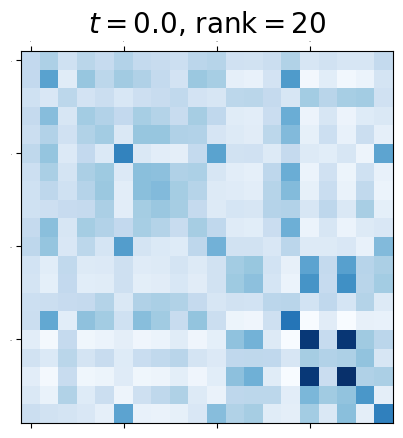

20


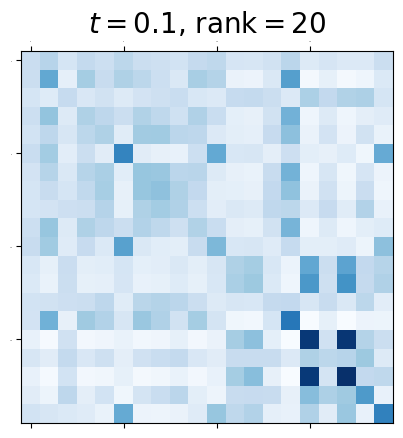

20


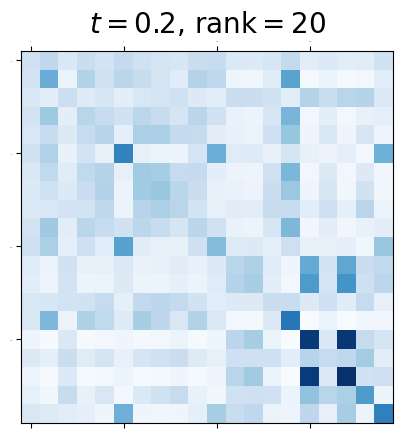

20


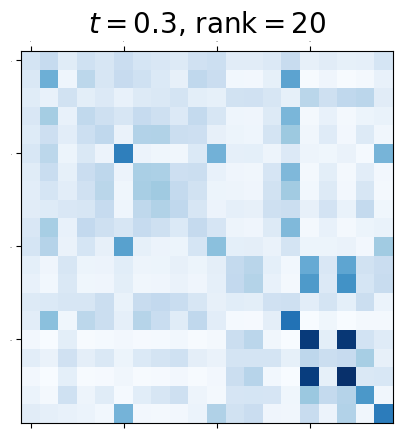

20


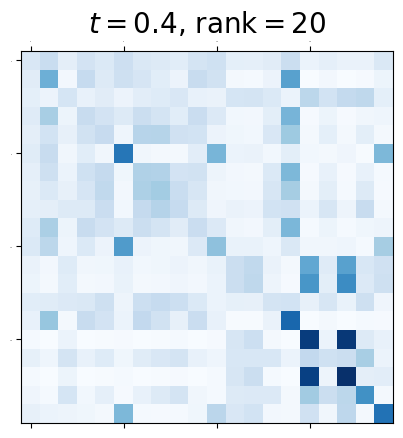

20


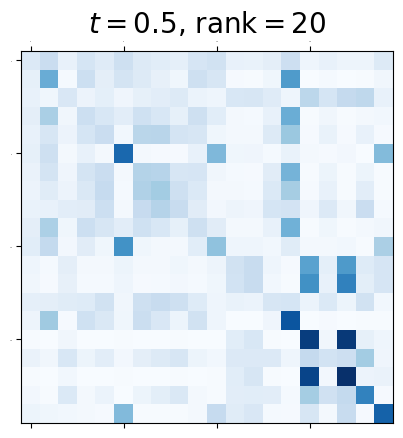

20


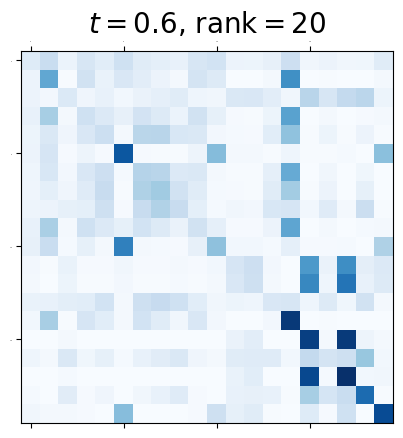

20


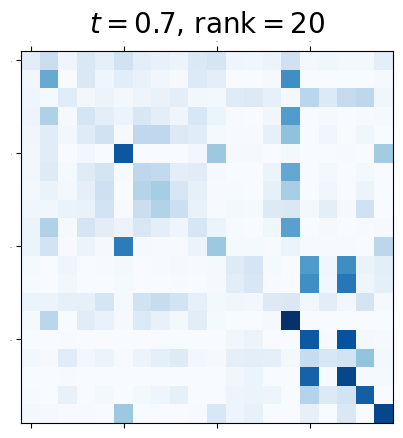

20


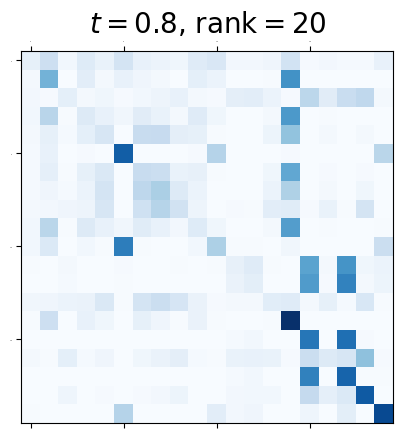

20


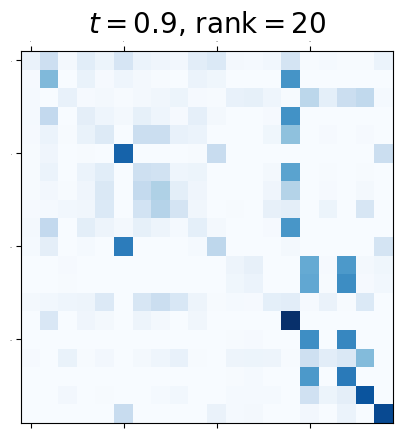

20


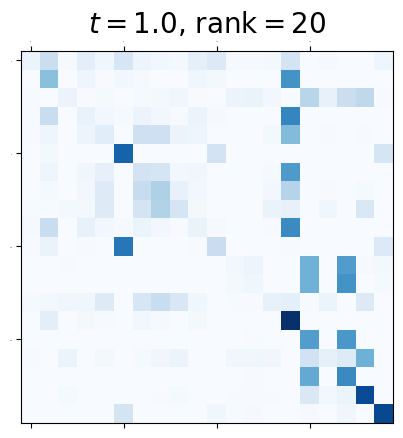

20


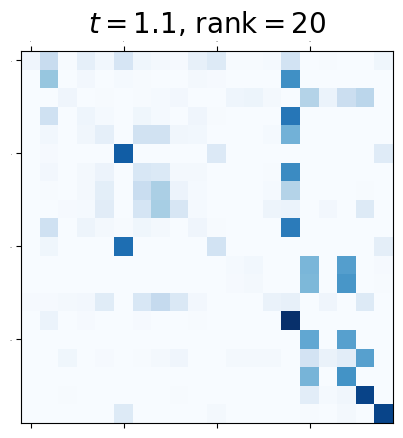

20


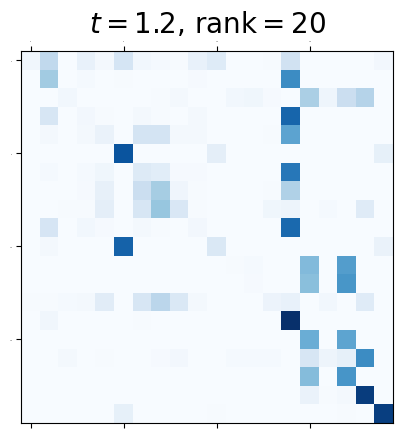

20


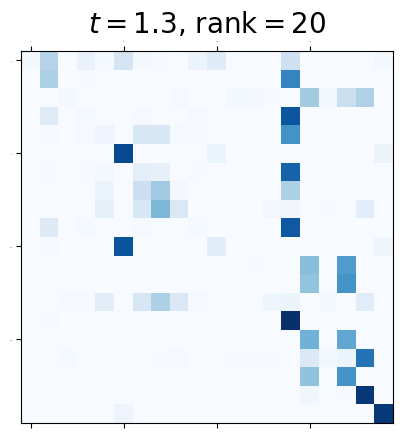

20


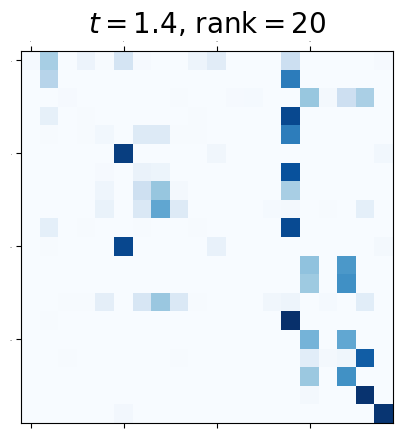

20


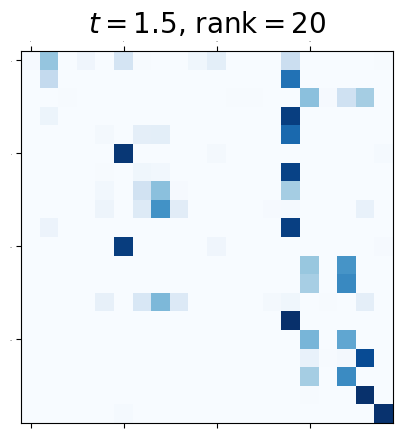

20


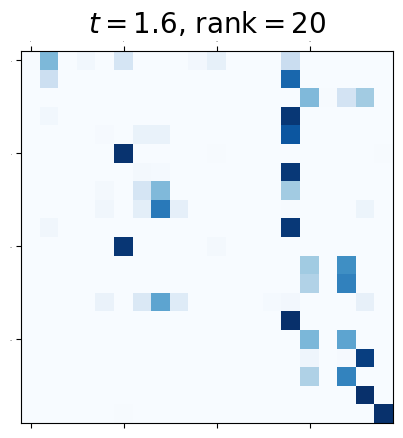

20


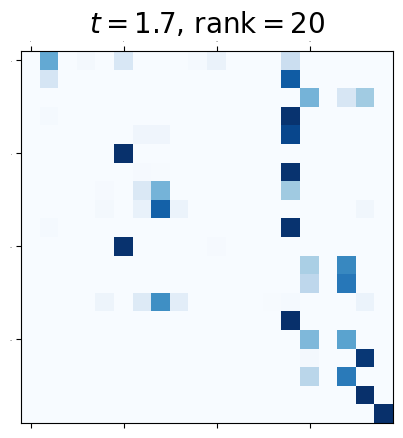

20


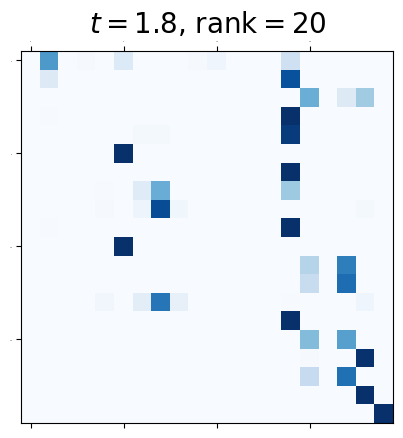

20


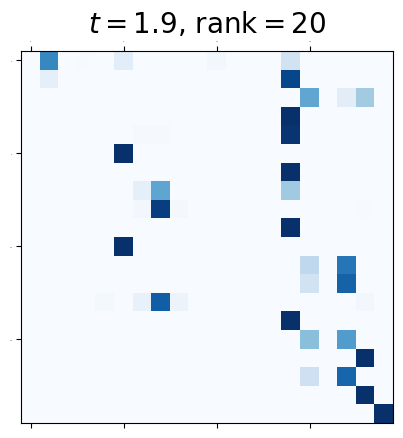

20


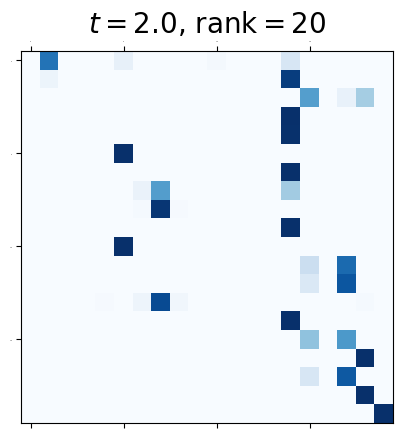

19


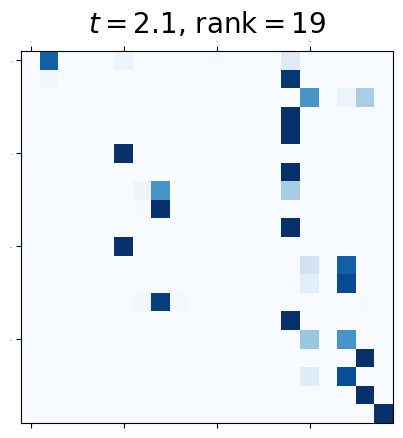

18


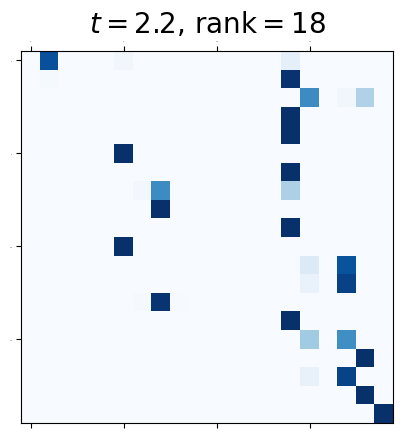

17


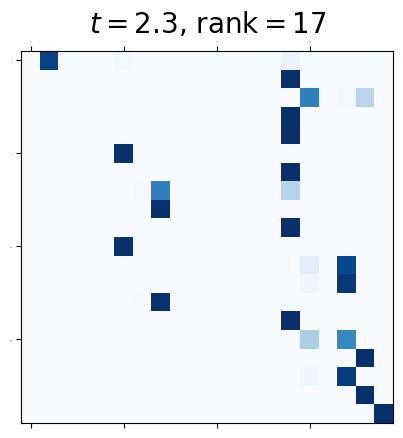

15


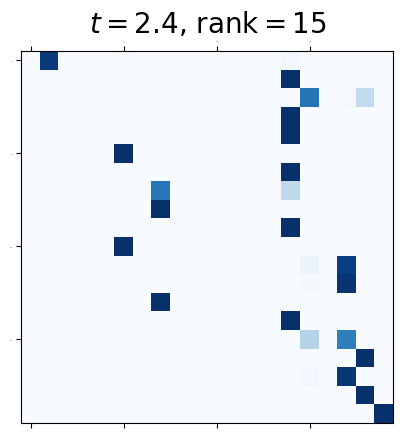

14


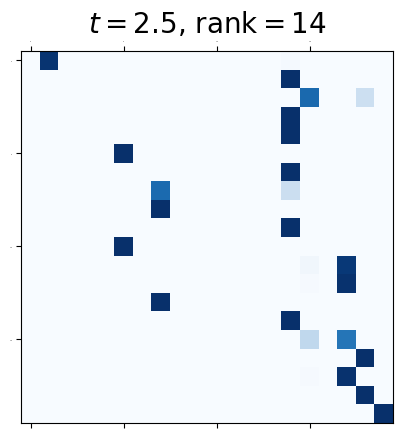

11


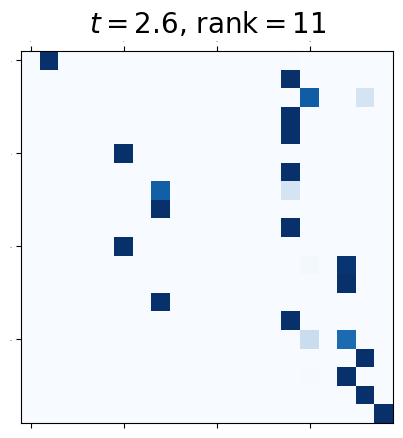

11


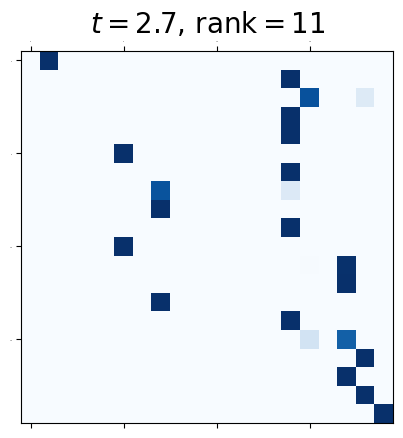

10


/scratch/902496/ipykernel_2044085/2639188945.py:4: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


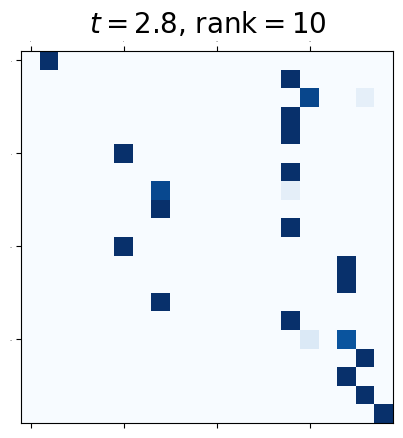

10


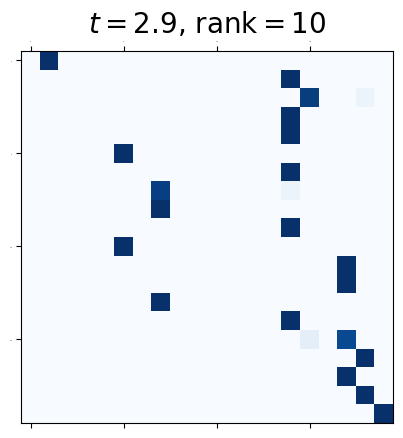

10


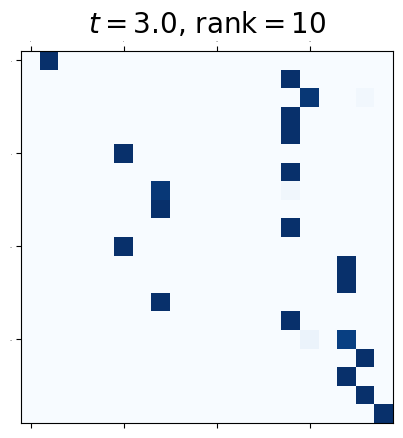

10


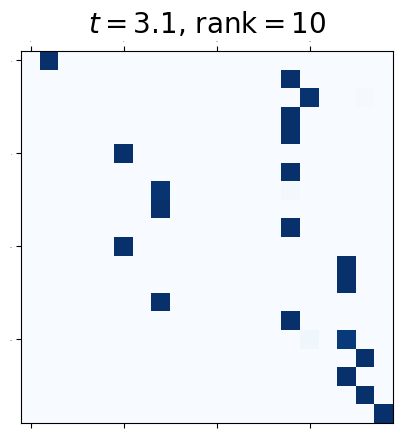

9


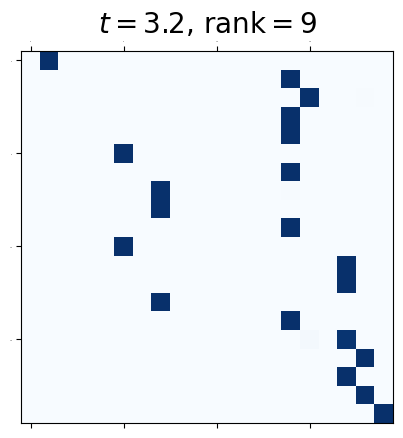

9


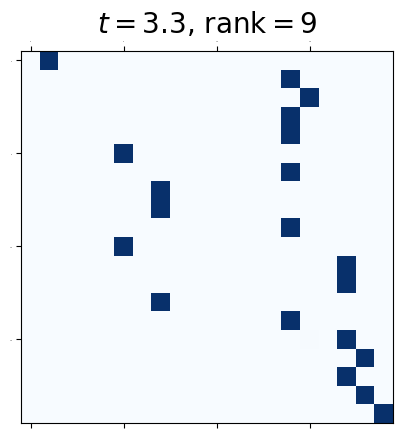

8


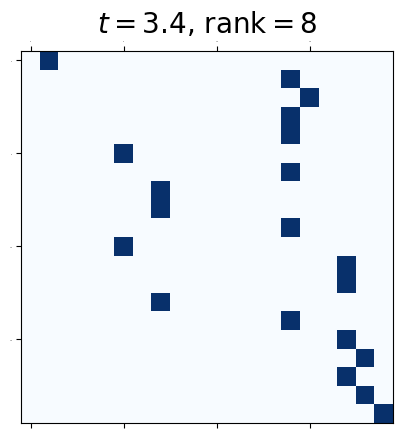

8


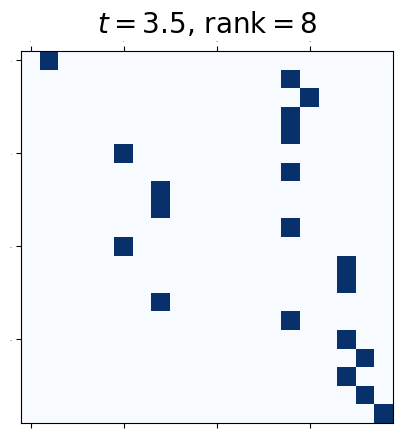

8


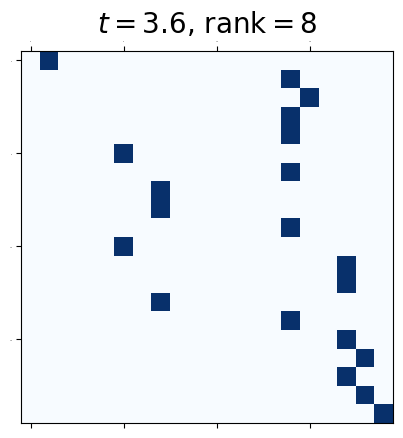

8


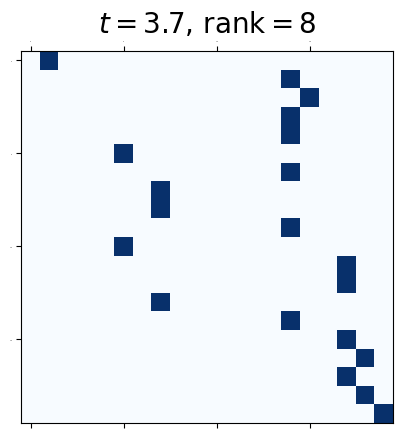

8


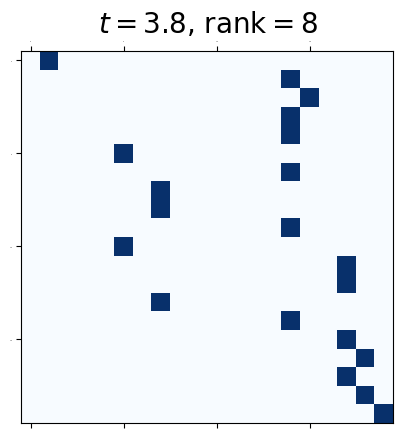

8


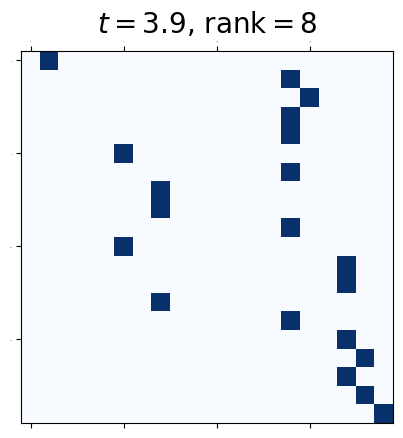

8


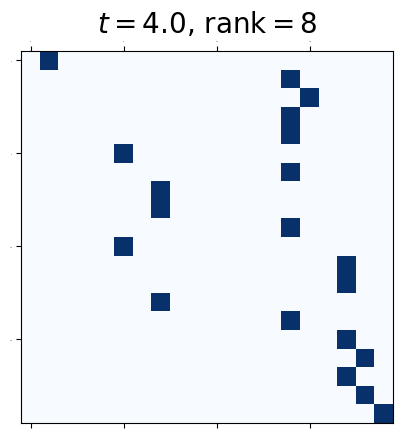

8


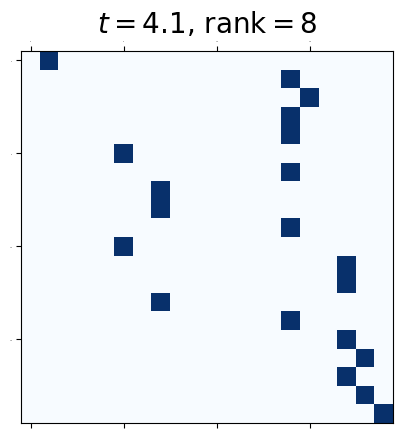

8


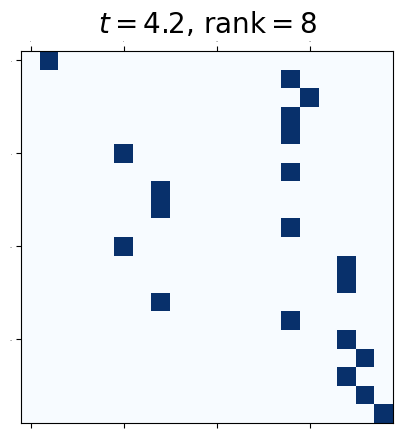

8


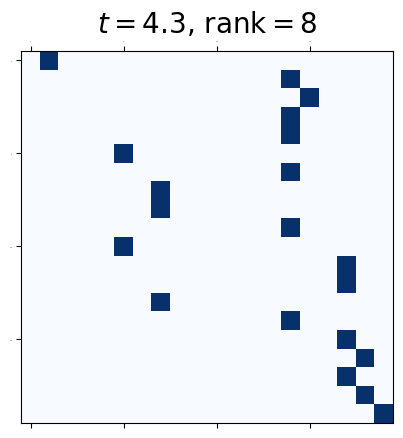

8


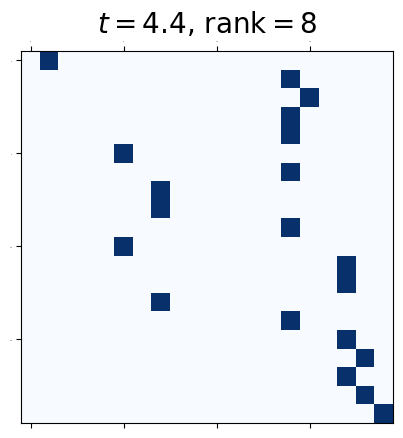

8


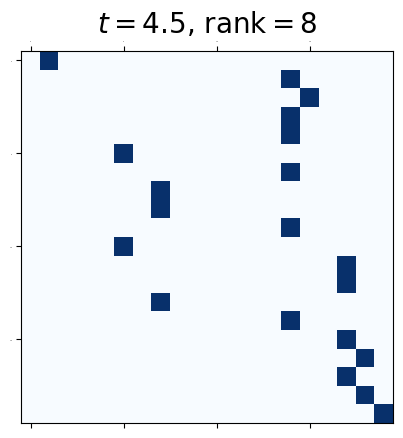

8


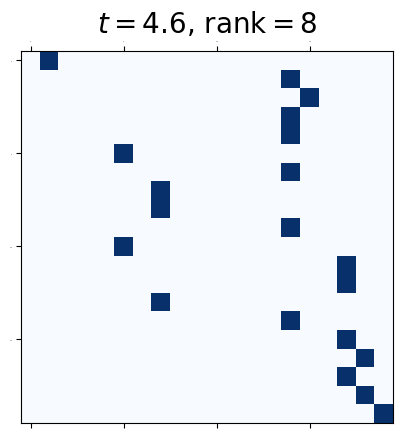

8


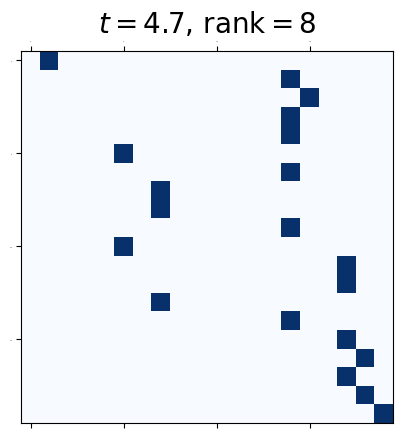

8


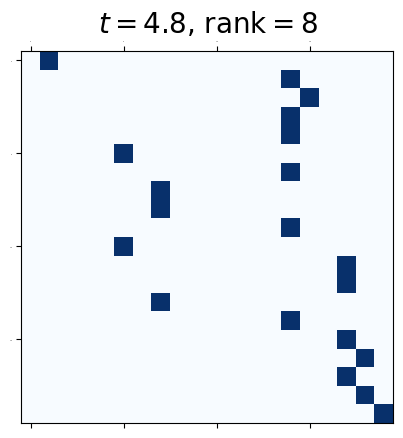

8


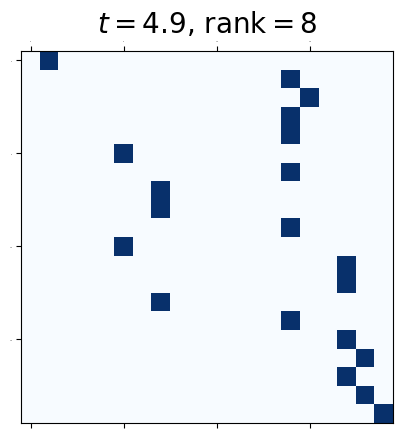

8


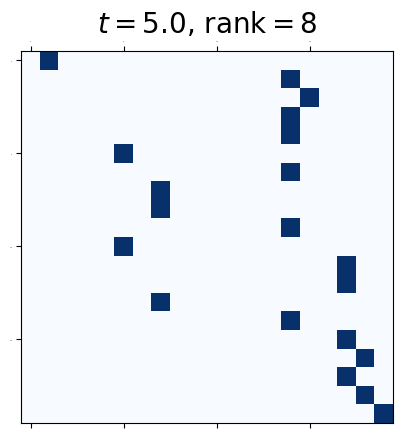

8


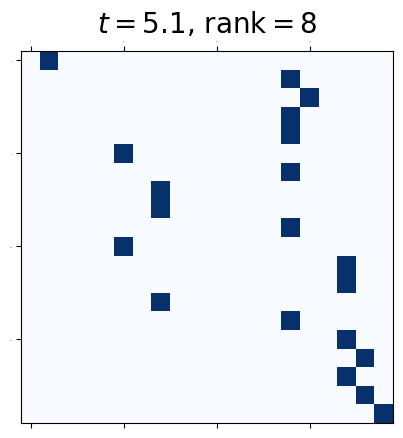

8


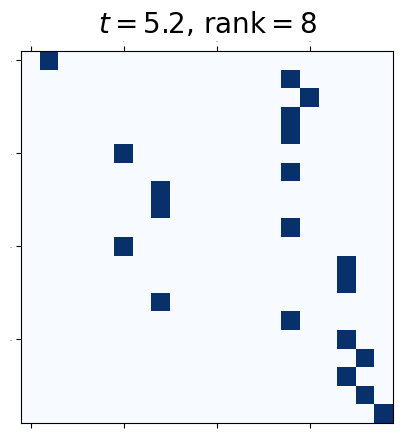

8


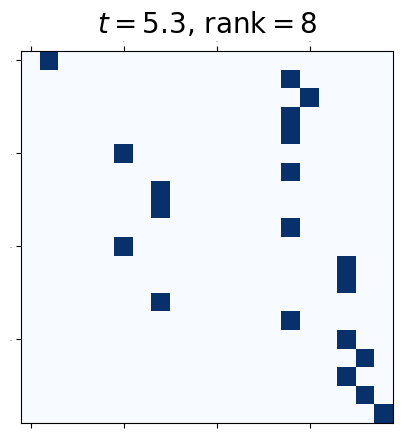

8


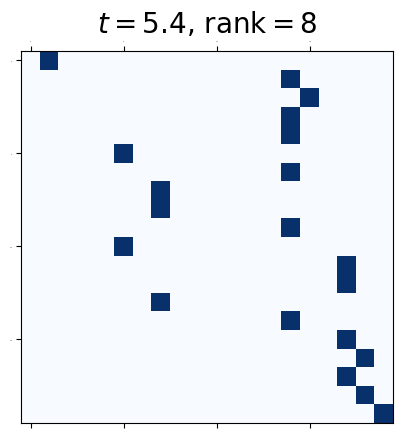

8


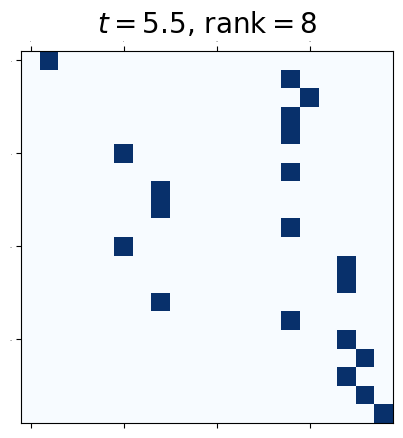

8


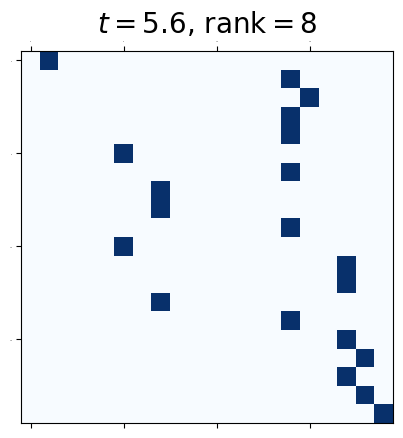

8


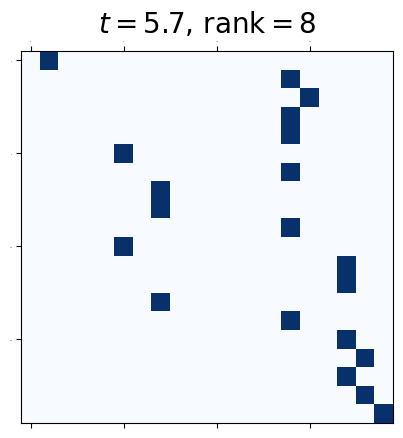

8


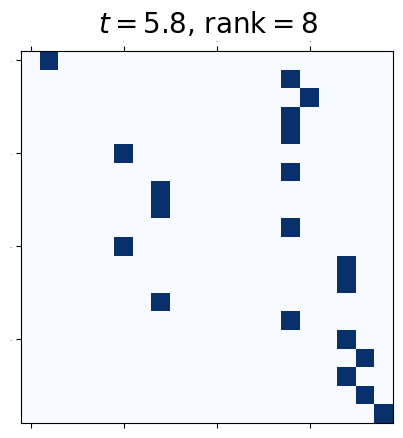

8


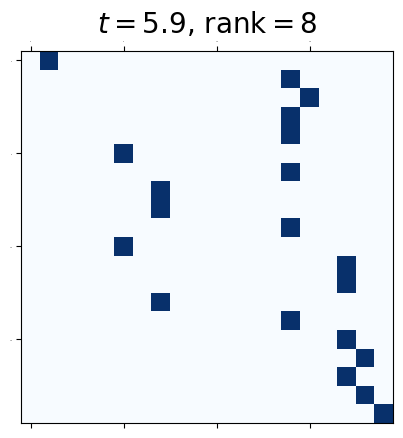

In [89]:
# simulation
for l, t in enumerate(integration_time):
    if l<num_steps-1:
        attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]
        print(np.linalg.matrix_rank(attention))

        label_size = 0
        plt.matshow(attention, cmap="Blues")
        plt.rcParams['xtick.labelsize'] = label_size
        plt.rcParams['ytick.labelsize'] = label_size
        plt.title(r'$t={t}$, rank$={r}$'.format(t=str(round(t, 2)), r=str(np.linalg.matrix_rank(attention))), fontsize=20)
        plt.show()

        plt.clf()
        plt.close()
            
        # perform update, this one is rkhf
        x = rk4(attention, V, x, n, dt) 

# Main experiment using transformer

Haven't imlemented this one, but they look at albert weights

In [ ]:
import numpy as np
import scipy as sp
import imageio
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from datetime import datetime


def get_dynamics(z_curr, attention, V, i):
    """
    - Returns: the dynamics z'(t) = (z_1'(t), ... , z_n'(t)) at some time-step t.
    """
    
    dlst = np.array([attention[i][j]*np.matmul(V, z_curr[j]-z_curr[i]) for j in range(n)])
    return np.sum(dlst, axis=0)

def transformer(T, dt, n, d, A, V, x0):
    """
    - Returns: the evolution of z = (z_1, ..., z_n) over time.
    """
    
    num_steps = int(T/dt)+1
    z = np.zeros(shape=(n, num_steps, d))
    z[:, 0, :] = x0
    integration_time = np.linspace(0, T, num_steps)

    for l, t in enumerate(integration_time):
        if l < num_steps - 1:
            # Attention matrix
            attention = [[1/np.sum([np.exp(np.dot(np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[i][l]), np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[k][l]-z[j][l]))) for k in range(n)]) for j in range(n)] for i in range(n)]
            
            z_next = np.zeros((n, d))
            for i in range(n):
                k1 = dt * get_dynamics(z[:, l, :], attention, V, i)
                k2 = dt * get_dynamics(z[:, l, :] + k1 / 2, attention, V, i)
                k3 = dt * get_dynamics(z[:, l, :] + k2 / 2, attention, V, i)
                k4 = dt * get_dynamics(z[:, l, :] + k3, attention, V, i)
                
                z_next[i] = z[i][l] + (k1 + 2*k2 + 2*k3 + k4) / 6
        
            z[:, l+1, :] = z_next
    return z

def calculate_distance_from_viewing_direction(point):
    viewing_direction = np.array([1, 0, 0])
    return np.linalg.norm(point - viewing_direction)

def visuals(d, 
            dt, 
            z, 
            integration_time, 
            conv, 
            color, 
            show_polytope, 
            movie, 
            dir_path, 
            base_filename):
    """
    Plots several snapshots of the trajectories {z_i(t)}_{i\in[n]}, and a movie thereof
    if indicated.
    """
    
    x_min, x_max = z[:, :, 0].min(), z[:, :, 0].max()
    if d>1:
        y_min, y_max = z[:, :, 1].min(), z[:, :, 1].max()
        if d == 3:
            z_min, z_max = z[:, :, 2].min(), z[:, :, 2].max()
    
    margin = 0.1
    x_range = x_max - x_min
    x_min -= margin * x_range
    x_max += margin * x_range

    if d>1:
        y_range = y_max - y_min
        y_min -= margin * y_range
        y_max += margin * y_range
        if d == 3:
            z_range = z_max - z_min
            z_min -= margin * z_range
            z_max += margin * z_range
    
    interp_x = []
    interp_y = []
    interp_z = []

    for i in range(n):
        interp_x.append(interp1d(integration_time, z[i, :, 0], 
                                 kind='cubic', 
                                 fill_value='extrapolate'))
        if d>1:
            interp_y.append(interp1d(integration_time, z[i, :, 1], 
                                     kind='cubic', 
                                     fill_value='extrapolate'))
            if d==3:
                interp_z.append(interp1d(integration_time, z[i, :, 2], 
                                         kind='cubic', 
                                         fill_value='extrapolate'))
                
    rc("text", usetex = True)
    font = {'size'   : 16}
    rc('font', **font)
    
    for t in range(num_steps):
        if d == 2 and round(t*dt % 0.5, 10) == 0:
            label_size = 16
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            plt.title(r'$t={t}$'.format(t=str(round(t*dt, 2))), fontsize=20)
                
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            ax.set_aspect('equal', adjustable='box')
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            plt.scatter([x(integration_time)[t] for x in interp_x], 
                        [y(integration_time)[t] for y in interp_y], 
                        c=color, 
                        alpha=1, 
                        marker = 'o', 
                        linewidth=0.75, 
                        edgecolors='black', 
                        zorder=3)
            
            plt.scatter([x(integration_time)[0] for x in interp_x], 
                        [y(integration_time)[0] for y in interp_y], 
                        c='white', 
                        alpha=0.1, 
                        marker = '.', 
                        linewidth=0.3, 
                        edgecolors='black', 
                        zorder=3)
            
            if t > 0:
                for i in range(n):
                    x_traj = interp_x[i](integration_time)[:t+1]
                    y_traj = interp_y[i](integration_time)[:t+1]
                    plt.plot(x_traj, 
                             y_traj, 
                             c=color, 
                             alpha=1, 
                             linewidth = 0.25, 
                             linestyle = 'dashed',
                             zorder=1)
            if conv:
                points = np.array([[z[i, t, 0], 
                                    z[i, t, 1]] for i in range(n)])
                hull = ConvexHull(points)
                for simplex in hull.simplices:
                    plt.plot(points[simplex, 0], 
                             points[simplex, 1], 
                             color='silver',
                             linewidth = 0.5,
                             alpha=1)
            
            plt.savefig(base_filename + "{}.pdf".format(t), 
                        format='pdf', 
                        bbox_inches='tight')
                    
        elif d == 3 and round(t*dt % 0.5, 10) == 0:
            fig = plt.figure()
            ax = Axes3D(fig)
            label_size = 16
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size
            
            plt.title(r'$t={t}$'.format(t=str(round(t*dt,2))), fontsize=20)
                
            ax.scatter([x(integration_time)[t] for x in interp_x], 
                        [y(integration_time)[t] for y in interp_y],
                        [z(integration_time)[t] for z in interp_z],
                        c=color, 
                        alpha=1, 
                        marker = 'o', 
                        linewidth=0.75, 
                        edgecolors='black')
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            
            ax.scatter([x(integration_time)[0] for x in interp_x], 
                        [y(integration_time)[0] for y in interp_y],
                        [z(integration_time)[0] for z in interp_z], 
                        c='white', 
                        alpha=0.1, 
                        marker = '.', 
                        linewidth=0.3, 
                        edgecolors='black', 
                        zorder=3)
            
            if t > 0:
                for i in range(n):
                    x_traj = interp_x[i](integration_time)[:t+1]
                    y_traj = interp_y[i](integration_time)[:t+1]
                    z_traj = interp_z[i](integration_time)[:t+1]
                    ax.plot(x_traj, 
                            y_traj, 
                            z_traj, 
                            c=color, 
                            alpha=0.75, 
                            linestyle = 'dashed',
                            linewidth = 0.25)
            
            ax.set_xlim3d(x_min, x_max)
            ax.set_ylim3d(y_min, y_max)
            ax.set_zlim3d(z_min, z_max)
            
            ax.view_init(elev=10)
        
            ax.grid(False)
            plt.locator_params(nbins=4)
            
            if conv:
                points = np.array([[z[i, t, 0], 
                                    z[i, t, 1],
                                    z[i, t, 2]] for i in range(n)])
                hull = ConvexHull(points)
                for simplex in hull.simplices:
                    plt.plot(points[simplex, 0], 
                             points[simplex, 1], 
                             points[simplex, 2],
                             color='silver',
                             linewidth = 0.5,
                             alpha=1)
            
            plt.savefig(os.path.join(dir_path, base_filename + "{}.pdf".format(t)), 
                        format='pdf', 
                        bbox_inches='tight')
            
            if t == num_steps-1 and show_polytope:
                
                from mpl_toolkits.mplot3d.art3d import Poly3DCollection
                fig = plt.figure()
                ax = Axes3D(fig)
                plt.title("")
                fig.set_facecolor('white')
                ax.set_facecolor('white') 
                ax.grid(False) 
                ax.w_xaxis.pane.fill = False
                ax.w_yaxis.pane.fill = False
                ax.w_zaxis.pane.fill = False
                ax.set(xlabel='')

                # Remove y-axis label
                ax.set(ylabel='')
                ax.set_zlabel('')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                    
                ax.scatter([x(integration_time)[t] for x in interp_x], 
                            [y(integration_time)[t] for y in interp_y],
                            [z(integration_time)[t] for z in interp_z],
                            c=color, 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black')
                plt.rc('text', usetex=True)
                plt.rc('font', family='serif')
                
                ax.scatter([x(integration_time)[0] for x in interp_x], 
                            [y(integration_time)[0] for y in interp_y],
                            [z(integration_time)[0] for z in interp_z], 
                            c='white', 
                            alpha=0.1, 
                            marker = '.', 
                            linewidth=0.3, 
                            edgecolors='black', 
                            zorder=3)
                
                
                points = np.array([[z[i, t, 0], 
                                    z[i, t, 1],
                                    z[i, t, 2]] for i in range(n)])
                hull = ConvexHull(points)
                
                cmap = plt.cm.get_cmap("plasma")
                
                for s in hull.simplices:
                    s = np.append(s, s[0])  # Here we cycle back to the first vertex in each simplex.
                    poly = Poly3DCollection([points[s]])
                    
                    min_x = np.min(points[s][:, 0])
                    color = cmap(min_x / 8)
            
                    # Calculate alpha based on the minimum X-coordinate, with front facets being more transparent.
                    alpha = 0.35 - 0.15 * (min_x / 8)
                    
                    poly.set_facecolor((*color[:3], alpha))  # Set the facecolor with the calculated color and alpha value.
                    ax.add_collection3d(poly)
                    
                for i in range(n):
                    x_traj = interp_x[i](integration_time)[:t+1]
                    y_traj = interp_y[i](integration_time)[:t+1]
                    z_traj = interp_z[i](integration_time)[:t+1]
                    ax.plot(x_traj, 
                            y_traj, 
                            z_traj, 
                            c='#FA7000', 
                            alpha=1, 
                            linestyle = 'dashed',
                            linewidth = 0.6)
                   
                ax.view_init(elev=10)
                
                plt.savefig(os.path.join(dir_path, base_filename + "{}.pdf".format(t+1)), 
                            format='pdf', 
                            bbox_inches='tight')
         
        if movie:           
            plt.savefig(base_filename + "{}.png".format(t),
                        format='png', dpi=250, bbox_inches=None)
        plt.clf()
        plt.close()
        
    if movie:
        imgs = []
        for i in range(num_steps):
            img_file = base_filename + "{}.png".format(i)
            imgs.append(imageio.imread(img_file))
            os.remove(img_file) 
        imageio.mimwrite(os.path.join(dir_path, filename), imgs)
 

geometries = ["polytope", "hyperplanes", "codimension-k", "hyperplanes x polytope"]
T = 5
dt = 0.1
n = 20
d = 2
x0 = np.random.uniform(low=-5, high=5, size=(n, d))
num_steps = int(T/dt)+1
integration_time = np.linspace(0, T, num_steps)

movie = False
conv = False
show_polytope = False

# An example
choice = "polytope"

if choice not in geometries:
    import sys
    print("Element is not in the list")
    sys.exit()
print("Element is in the list")

if choice == "polytope":
    # Theorem 3.2 (Clustering to a convex polytope)
    A = np.eye(d)
    V = np.eye(d)
    dir_path = './Th31'
    color = '#FA7000'
    conv = True

if choice == "hyperplanes":
    # Theorem 3.1 (Clustering to hyperplanes)
    A = np.eye(d)
    V = np.random.rand(d, d)
    V = np.abs(V)               # Perron Frobenius
    print("Eigenvalues of V:")
    print(np.linalg.eigvals(V))
    # Example in paper (2d):
    # V = np.array([[0.64709742, 0.81911926],
    #                0.61210449, 0.63263484]])
    # Example in paper (3d; Re(l)<0):
    # V = np.array([[0.2362413 , 0.0599536 , 0.40506019],
    #         [0.81321448, 0.49948705, 0.33754772],
    #         [0.2160645 , 0.38505272, 0.14588075]])
    # # Example 2 in paper (3d; Re(l)>0):
    # V = np.array([[0.18608476, 0.34391026, 0.13905949],
    #         [0.35244288, 0.6694859 , 0.39992145],
    #         [0.46685606, 0.17094454, 0.42092308]])
    dir_path = './Th41'
    color = '#3a4cc1'

if choice == "codimension-k":
    # Conjecture (codimension-k)
    A = np.eye(d)
    V = np.random.rand(d, d)
    V = (V+V.T)/2
    print("Eigenvalues of V:")
    print(np.linalg.eigvals(V))
    # Example in paper: Real eigenvalues (2 positive, 1 negative)
    # V = np.array([[0.92761287, 0.94333073, 0.3827744 ],
    #         [0.94333073, 0.59991396, 0.47825472],
    #         [0.3827744 , 0.47825472, 0.46668605]])
    dir_path = './Conj'
    color = '#9f4292'

if choice == "hyperplanes x polytope":
    # Theorem 5.1 (Clustering to a polytope and hyperplane)
    A = np.eye(d)
    # Example in paper:
    V = np.eye(d)
    V[-1][-1] = -0.5
    dir_path = './Th51'
    color = '#63acbe'
    conv = True
    
# The trajectories
z = transformer(T, dt, n, d, A, V, x0)

# Set the directory path where you want to save the pictures
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Generate the filename using the current datetime
now = datetime.now()
dt_string = now.strftime("%H-%M-%S")
filename = dt_string + ".gif"
base_filename = dt_string 
    
visuals(d, dt, z, integration_time, conv, color, show_polytope, movie, dir_path, base_filename)

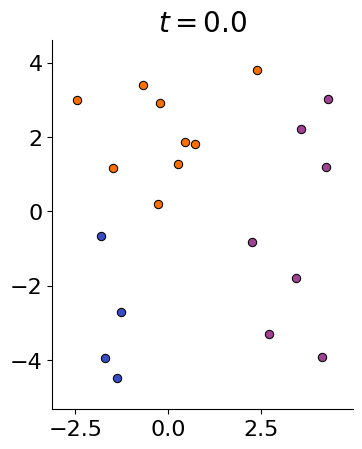

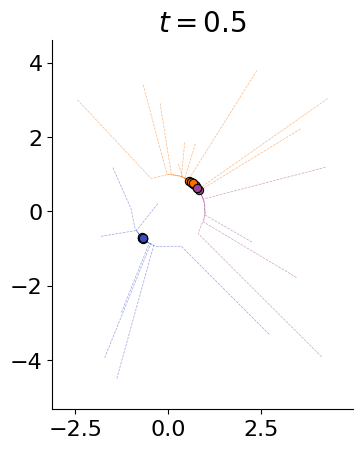

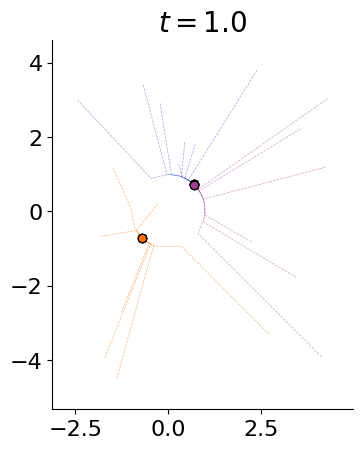

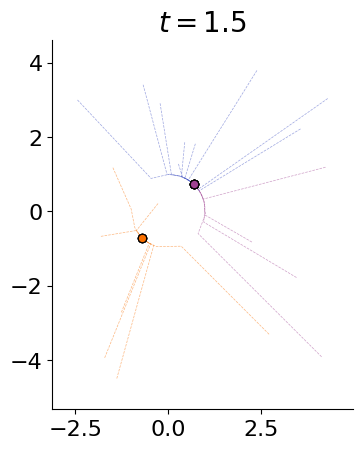

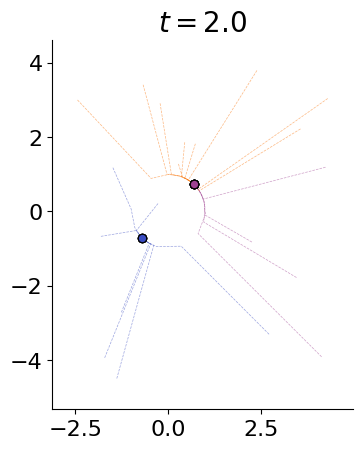

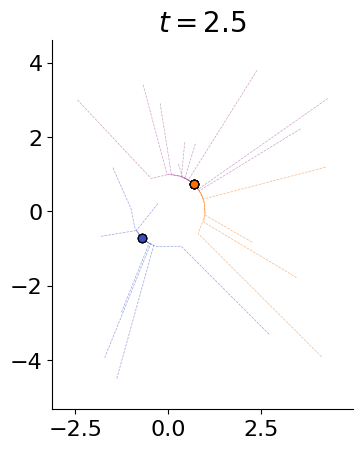

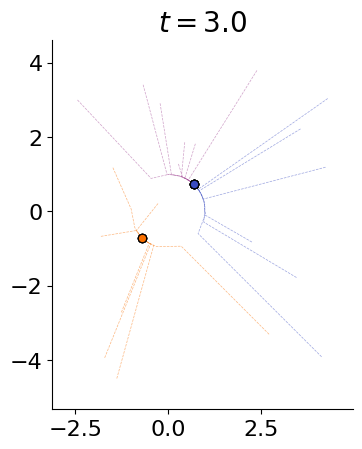

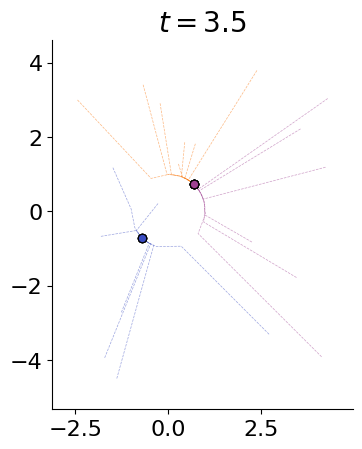

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


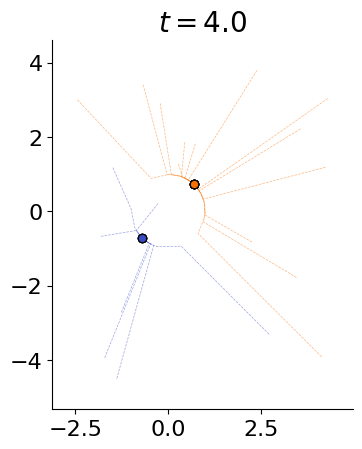

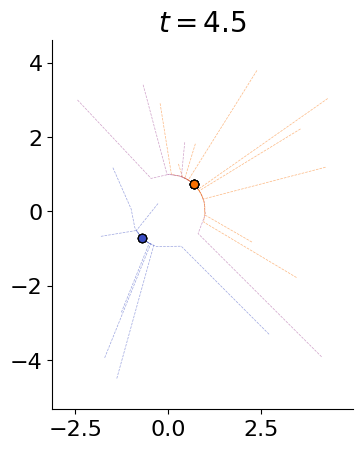

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


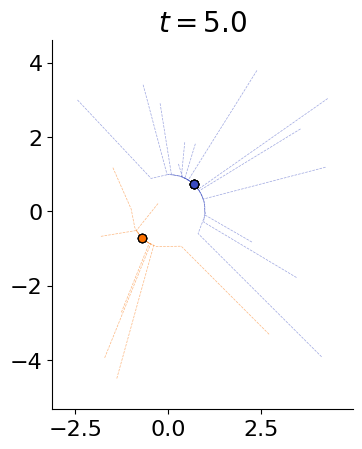

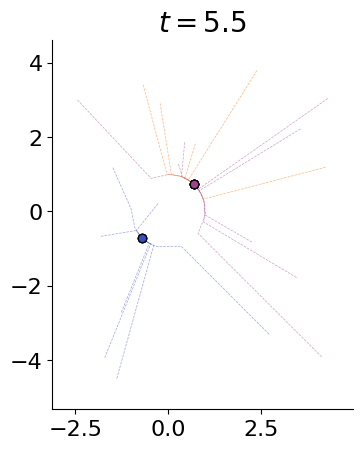

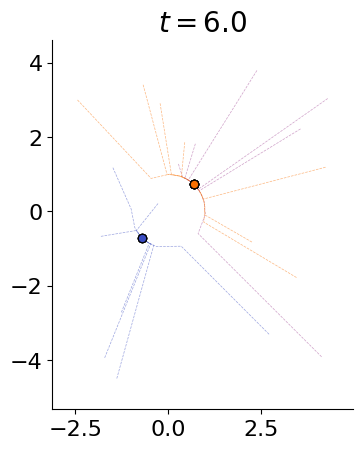

In [134]:
# we can allow the k and v seqlen to be different from q
num_queries = 10
m = 20

# Initialize query tokens (q_i), key tokens (k_i), and value tokens (v_i)
q0 = np.random.uniform(low=-5, high=5, size=(n, d))

# instead of randomly generating these, we could force assign them to clusters
from sklearn.datasets import make_blobs

m = 60
centers = [(-1, -1), (1, 0), (0, 1)]
k, true_labels = make_blobs(n_samples=m, centers=centers, cluster_std=1.0, random_state=42)
v = k.copy()  # Use the same values for v for simplicity
# k = np.random.uniform(low=-5, high=5, size=(m, d))
# v = np.random.uniform(low=-5, high=5, size=(m, d))

# arr = np.ones((n, d))
# q0, k, v = arr, arr * 2, arr * 3

def get_dynamics_cross_attention(q_curr, k, v, i):
    """
    Compute the dynamics for query token q_i using cross-attention.
    """
    # Compute attention weights between q_i and all key tokens
    scores = np.array([np.dot(np.matmul(A, q_curr[i]), np.matmul(A, k_j)) for k_j in k])
    attention_weights = np.exp(scores) / np.sum(np.exp(scores))
    
    # Compute the weighted sum of value tokens
    weighted_v = np.sum([attention_weights[j] * v[j] for j in range(len(k))], axis=0)
    
    # Compute the dynamics
    dz_dt = np.matmul(V, weighted_v - q_curr[i])
    return dz_dt

def transformer_cross_attention(T, dt, n, d, A, V, q0, k, v):
    """
    Simulate the dynamics of query tokens under cross-attention.
    """
    num_steps = int(T/dt) + 1
    q = np.zeros((n, num_steps, d))
    q[:, 0, :] = q0

    for l in range(num_steps - 1):
        q_next = np.zeros((n, d))
        for i in range(n):
            # Runge-Kutta 4th order method for integration
            k1 = dt * get_dynamics_cross_attention(q[:, l, :], k, v, i)
            k2 = dt * get_dynamics_cross_attention(q[:, l, :] + k1 / 2, k, v, i)
            k3 = dt * get_dynamics_cross_attention(q[:, l, :] + k2 / 2, k, v, i)
            k4 = dt * get_dynamics_cross_attention(q[:, l, :] + k3, k, v, i)
            
            q_next[i] = q[i, l, :] + (k1 + 2*k2 + 2*k3 + k4) / 6

        q[:, l+1, :] = q_next
        
        
        # lets do a linear projection of them back onto hyerphere
        q[:, l+1, :] = layer_normalize(q[:, l+1, :], radius=1)

    return q

def visualize_clustering(q, integration_time, dir_path, base_filename):
    """
    Visualize the clustering of query tokens over time.
    """
    x_min, x_max = q[:, :, 0].min(), q[:, :, 0].max()
    y_min, y_max = q[:, :, 1].min(), q[:, :, 1].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range

#     rc("text", usetex=True)
#     font = {'size': 16}
#     rc('font', **font)

    for t in range(num_steps):
        if round(t * dt % 0.5, 10) == 0:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            plt.rcParams['xtick.labelsize'] = 16
            plt.rcParams['ytick.labelsize'] = 16
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            plt.title(r'$t={t}$'.format(t=str(round(t * dt, 2))), fontsize=20)
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            ax.set_aspect('equal', adjustable='box')
#             plt.rc('text', usetex=True)
#             plt.rc('font', family='serif')

            # cluster
            points = q[:, t, :]
            clustering = KMeans(n_clusters=3).fit(points)
            labels = clustering.labels_
            colors = ['#FA7000', '#3a4cc1', '#9f4292']

            for i in range(n):
                plt.scatter(points[i, 0], points[i, 1], c=colors[labels[i] % 3],
                            alpha=1, marker='o', linewidth=0.75, edgecolors='black', zorder=3)

            # Plot trajectories
            if t > 0:
                for i in range(n):
                    x_traj = q[i, :t+1, 0]
                    y_traj = q[i, :t+1, 1]
                    plt.plot(x_traj, y_traj, c=colors[labels[i] % 3],
                             alpha=0.5, linewidth=0.5, linestyle='dashed', zorder=1)

            # plt.savefig(os.path.join(dir_path, base_filename + "{}.pdf".format(t)),
#                         format='pdf', bbox_inches='tight')
            plt.show()
            plt.clf()
            plt.close()


q = transformer_cross_attention(T, dt, n, d, A, V, q0, k, v)

dir_path = './CrossAttentionClustering'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

now = datetime.now()
dt_string = now.strftime("%H-%M-%S")
base_filename = dt_string

visualize_clustering(q, integration_time, dir_path, base_filename)


In [126]:
q_final = q[:, -1, :]

distances = cdist(k, q_final)
cluster_assignments = np.argmin(distances, axis=1)

In [127]:
silhouette = silhouette_score(k, cluster_assignments)
calinski_harabasz = calinski_harabasz_score(k, cluster_assignments)
davies_bouldin = davies_bouldin_score(k, cluster_assignments)

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

# off change we create random matrices, not from blobs
if true_labels is not None:
    ari = adjusted_rand_score(true_labels, cluster_assignments)
    nmi = normalized_mutual_info_score(true_labels, cluster_assignments)

    print(f"Adjusted Rand Index: {ari}")
    print(f"Normalized Mutual Information: {nmi}")

Silhouette Score: -0.026525483606482103
Calinski-Harabasz Index: 35.24193825861927
Davies-Bouldin Index: 3.1157049890088344
Adjusted Rand Index: 0.34476230057029394
Normalized Mutual Information: 0.41932610943369547


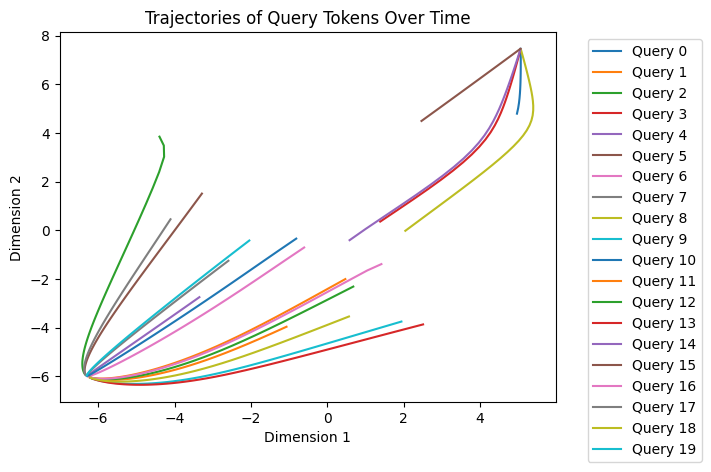

In [128]:
for i in range(n):
    plt.plot(q[i, :, 0], q[i, :, 1], label=f'Query {i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Trajectories of Query Tokens Over Time')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

/scratch/902496/ipykernel_2044085/3458614494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)


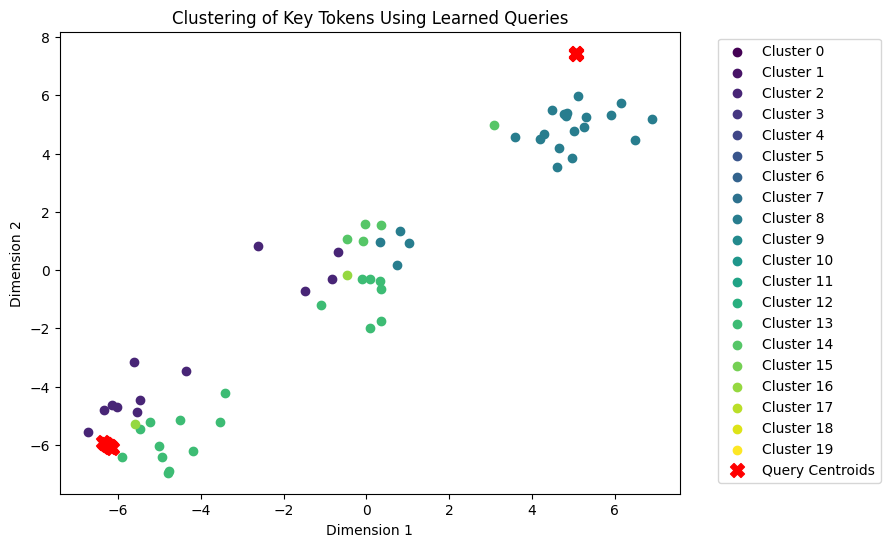

In [129]:
def visualize_clustering_results(input_tokens, q_final, cluster_assignments, title):
    n_clusters = len(q_final)
    colors = plt.cm.get_cmap('viridis', n_clusters)
    
    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        indices = np.where(cluster_assignments == i)
        plt.scatter(input_tokens[indices, 0], input_tokens[indices, 1], 
                    color=colors(i), label=f'Cluster {i}')
    
    plt.scatter(q_final[:, 0], q_final[:, 1], c='red', marker='X', s=100, label='Query Centroids')
    
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

visualize_clustering_results(k, q_final, cluster_assignments, 'Clustering of Key Tokens Using Learned Queries')

# for when v and k aren't the same
# distances = cdist(v, q_final)
# cluster_assignments = np.argmin(distances, axis=1)
# visualize_clustering_results(v, q_final, cluster_assignments, 'Clustering of Value Tokens Using Learned Queries')
